# Distinct element estimation using k-th min 

In the lecture, we studied the algorithm named Idealized $F_0$ estimation (slide 19). The algorithm uses a random hash function to map elements from the stream to float values between 0 and 1. Ultimately, it maintains the smallest hash value $V$ and outputs ${1\over V}-1$ as the estimate $\tilde{F}_0$ for the number of distinct elements.

This algorithm uses the idea that the expected value of the smallest hash value is $1\over F_0+1$, where $F_0$ is the number of distinct elements. In fact, we can generally use the $k$-th smallest hash value $V_k$ for $k=1,2,\dots$. We will use the results from exercise 4 to conduct experiments to see how different $k$ values affect the accuracy of your estimate.

[Optional]: Let m be the length of the stream. You can maintaining the k-th smallest element in an unsorted list in time $O(m\log k)$ using min heap, see https://docs.python.org/3/library/heapq.html. 

In [1]:
# Import packages needed.
import random, math
import numpy as np
import matplotlib.pyplot as plt

To test the effect of k, we must first implement a function that takes a data sequence, hash each element to a value between 0 and 1, and returns the k-th smallest hash value. Python has a built-in hash function hash() that takes any hashable object and returns an integer hash. To convert a hash value to a float, use modular the hash with a large int and divide by it, for instance, $MAXINT=2^{63}-1$.

In [2]:
import sys
MAXINT = sys.maxsize

In [3]:
def kth_smallest_hash_value(input_list, k):
#     Write your code here
    MAXINT = 2**63 - 1
    hash_values = [hash(item) % MAXINT for item in input_list]
    float_values = [hash_value / MAXINT for hash_value in hash_values]
    sorted_fpoints = sorted(float_values)
    return sorted_fpoints[k - 1]
    

Now let us test k values between 1 to 10. For each k, we will generate a list of 1000 random **strings** using ``str(random.uniform(0,100))``, and estimate its cardinality via the returned value from the function ``kth_smallest_hash_value`` you implemented. For each k, repeat this process 100 times and record the average and std of the estimates. Finally, generate a plot with error bars to show the relation between estimates and k values. Note that the std for small k can be very large, so you may need to set plt.ylim(-1000, 10000) to cap the y-axis for better visualization.

In [4]:
# Write your code here
ks = range(1,11)
ave = []
std = []
for k in ks:
    estimaterecord = []
    for itr in range(100):
        str_list = [str(random.uniform(0,100)) for _ in range(1000)]
        hash_value = kth_smallest_hash_value(str_list, k)
        estimate = int(k / hash_value) -1
        estimaterecord.append(estimate)
    ave.append(np.mean(estimaterecord))
    std.append(np.std(estimaterecord))

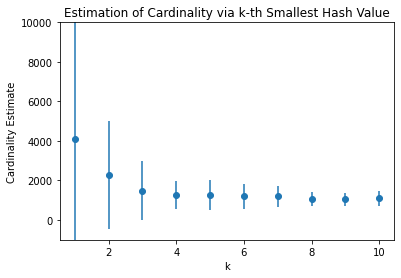

In [5]:
plt.errorbar(ks, ave, yerr=std, fmt='o')
plt.xlabel('k')
plt.ylabel('Cardinality Estimate')
plt.title('Estimation of Cardinality via k-th Smallest Hash Value')
plt.ylim(-1000, 10000)
plt.show()

## The median trick useful technique (slide 13)

Please implement the function ``median_trick`` below. 

In [6]:
def median_trick(generator, expectation, var, eps, delta):
    '''
    Input:
        generator - a function that generates one sample from a distribution when being called.
        expectation - Expectation of the distribution
        var - Variance of the distribution
        eps - epsilon (accuracy parameter) as defined in slide 13
        delta - delta (confidence parameter) as defined in slide 13
    Output:
        estimated value Q
    '''
    # Write your code here
    t = math.ceil(math.log(1/delta))
    k = math.ceil(var/(eps**2 * expectation**2))
    Qs = []
    for i in range(t):
        outputs = []
        for j in range(k):
            x = generator()
            outputs.append(x)
        Qs.append(np.mean(outputs))
    return np.median(Qs)
    

Now we want to test the function with the following idea. Assume Q=2. The unbiased estimator, X of Q, generates estimates that follow a normal distribution with variance equal to 1. The generator for X is already given below as ``normal_generator``. Please generate two plots below. 

- Set eps=0.1, and test how the delta affects the estimates. Range delta in [1e-6, 1e-4, 1e-3, 0.01, 0.1]; repeat the estimation 100 times for each delta value. Generate a plot with std as error bars to show how the average estimates change as the delta changes.

- Set delta=0.1, and test how the epsilon affects the estimates. Range epsilon in [0.01, 0.02, 0.05, 0.1, 0.2]; repeat the estimation 100 times for each epsilon value. Generate a plot with std as error bars to show how the average estimates change as the epsilon changes.

In [7]:
# Don't change
def normal_generator():
    return np.random.normal(2,1)

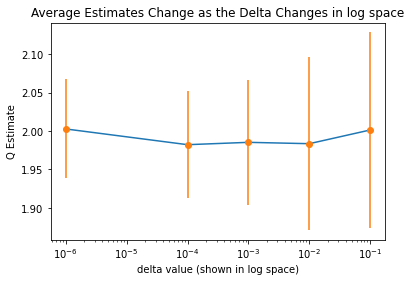

In [8]:
# Write your code here
trails = 100
# Case 1 delta changes
expQ = 2
var = 1
eps = 0.1
deltas = [1e-6, 1e-4, 1e-3, 0.01, 0.1]
ave_deltachanges = []
std_deltachanges = []
for delta in deltas:
    medians = []
    for i in range(trails):
        medians.append(median_trick(normal_generator, expQ, var, eps, delta))
    ave_deltachanges.append(np.mean(medians))
    std_deltachanges.append(np.std(medians))
plt.semilogx(deltas, ave_deltachanges)
plt.errorbar(deltas, ave_deltachanges, yerr=std_deltachanges, fmt='o')
plt.xlabel('delta value (shown in log space)')
plt.ylabel('Q Estimate')
plt.title('Average Estimates Change as the Delta Changes in log space')
plt.show()

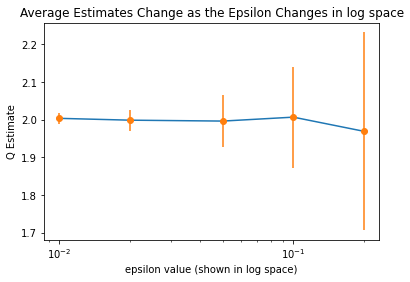

In [9]:
# Case 2 epsilon changes
trails = 100
expQ = 2
var = 1
delta = 0.1
epss = [0.01, 0.02, 0.05, 0.1, 0.2]
ave_epschanges = []
std_epschanges = []
for e in epss:
    medians = []
    for i in range(trails):
        medians.append(median_trick(normal_generator, expQ, var, e, delta))
    ave_epschanges.append(np.mean(medians))
    std_epschanges.append(np.std(medians))
plt.semilogx(epss, ave_epschanges)
plt.errorbar(epss, ave_epschanges, yerr=std_epschanges, fmt='o')
plt.xlabel('epsilon value (shown in log space)')
plt.ylabel('Q Estimate')
plt.title('Average Estimates Change as the Epsilon Changes in log space')
plt.show()

## Morris Algorithm (slide 45)

Morris algorithm maintains a counter c that, for every element in the stream, itself increments by 1 with probability $1\over 2^c$. In the end, it outputs an estimate as $2^c-1$.

In this section, we will change the base of this counter (slide 51). Instead of using 2 only, we use any base $1+\alpha$. We now increase the counter c with probability $1\over (1+\alpha)^c$. First, let us implement the function ``morris_update_base_alpha`` below. **This function is called whenever we see an element from the stream to update the counter.**

In [10]:
def morris_update_base_alpha(counter, alpha):
    '''
    Input:
        counter - current value of counter c
        alpha - as defined in slide 51 alpha
    Output:
        updated value of counter c
    '''
    base = 1.0 / (1 + alpha)**counter
    r = random.random()
    if r < base:
        counter += 1
    return counter


Now let us test the function with the edge list file "soc-hamsterster.edges" in the same folder. Reading the file line by line in python can generate a stream of strings. Counting the number of strings/lines in this file tells us the number of edges of this "soc-hamsterster" graph. Let us try different alpha values ranging from 2 to 9. Again, for each alpha, estimate the number of lines in the edge list file using the morris algorithm (the key component of which is ``morris_update_base_alpha``), and repeat this 100 times. Besides, check how many bits are needed to maintain the counter via ``math.ceil(math.log(counter, 2))`` at the end of each estimation. Finally, generate two plots with std as error bars to show 

- How the average estimate changes as the alpha value increases. 
- How the space usage (in bits) changes as the alpha value increases.

In [11]:
with open("soc-hamsterster.edges", "r") as f:
    edge_stream = f.readlines()

alphas = range(2,10)
trials = 100
ave_estimates = []
ave_space = []
std_estimates = []
std_space = []
for alpha in alphas:
    estimates = []
    usage = []
    for _ in range(trails):
        counter = 0
        for edge in edge_stream:
            counter = morris_update_base_alpha(counter, alpha)
        # transform counter to actual estimate here
        estimates.append((math.pow((1+alpha),counter) -1))
        usage.append(math.ceil(math.log(counter, 2)))
    ave_estimates.append(np.mean(estimates))
    std_estimates.append(np.std(estimates))
    ave_space.append(np.mean(usage))
    std_space.append(np.std(usage))
        

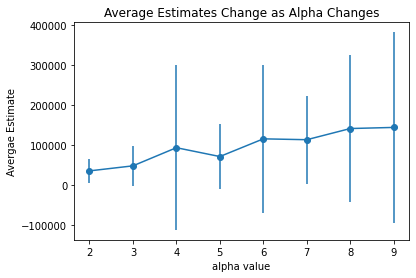

In [12]:
plt.errorbar(alphas, ave_estimates, yerr=std_estimates, fmt='-o')
plt.xlabel('alpha value')
plt.ylabel('Avergae Estimate')
plt.title('Average Estimates Change as Alpha Changes')
plt.show()

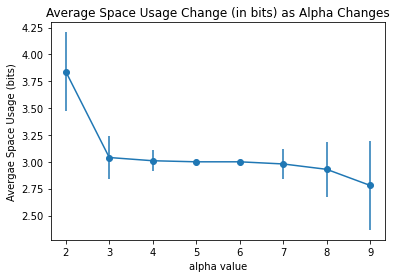

In [13]:
plt.errorbar(alphas, ave_space, yerr=std_space, fmt='-o')
plt.xlabel('alpha value')
plt.ylabel('Avergae Space Usage (bits)')
plt.title('Average Space Usage Change (in bits) as Alpha Changes')
plt.show()